In [1]:
import sys
sys.path.append("..")
import torch
from omegaconf import OmegaConf
from ccreaim.model import operate, ae
from ccreaim.utils import dataset, cfg_classes, audio_tools

data_tar = "/scratch/other/sopi/CCREAIM/datasets/test/out/chopped_65536.tar"
num_seq = 16
load_vqvae_path = "/scratch/other/sopi/CCREAIM/logs/2022-12-21/res-vqvae_train_00-06-09/2/checkpoints/res-vqvae_seqlen-4096_bs-128_lr-0.0001_seed-0_final.pt"

In [2]:
# Fetch the model

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

checkpoint = torch.load(load_vqvae_path, map_location="cpu")
model_state_dict = checkpoint["model_state_dict"]
hyper_cfg_schema = OmegaConf.structured(cfg_classes.HyperConfig)
conf = OmegaConf.create(checkpoint["hyper_config"])
hyper_cfg = OmegaConf.merge(hyper_cfg_schema, conf)
get_model = operate.get_model_init_function(hyper_cfg)
model = get_model()
model.load_state_dict(model_state_dict)
model = model.to(device)

In [3]:
# Prepare data
tmp_data_root = dataset.prepare_dataset_on_tmp(data_tar, hyper_cfg.seq_len)
data = dataset.ChunkedAudioDataset(tmp_data_root, hyper_cfg.seq_len, num_seq)


In [4]:
# Run a batch of chunked data through the vqvae 
with torch.inference_mode():
    # Encode data
    sample, _, _ = data[0]
    sample = sample.view(-1, 1, hyper_cfg.seq_len)
    enc_out_batch = model.encoder(sample)
    enc_out_batch = enc_out_batch.transpose(-1,-2)
    enc_out_length = ae.res_encoder_output_seq_length(hyper_cfg)
    enc_out = enc_out_batch.view(
                -1, num_seq, enc_out_length, hyper_cfg.latent_dim
    )
    enc_out_flat = enc_out.flatten(1, 2)  # merge into sequence of vectors

    # VQ
    quantized_latents, vq_inds = model.vq(enc_out_flat.transpose(-1, -2))
    vq_inds = vq_inds.view(-1, num_seq, enc_out_length)

    quantized_latents = quantized_latents.transpose(-1, -2)
    quantized_latents_res = (
        enc_out_flat + (quantized_latents - enc_out_flat).detach()
    )
    vq_out = quantized_latents_res.view(
        -1, enc_out_length, hyper_cfg.latent_dim
    )
    vq_out = vq_out.transpose(-1,-2)

    # Decode
    dec_out = model.decoder(vq_out)

In [5]:
orig_flat = sample.flatten().unsqueeze(0)
pred_flat = dec_out.flatten().unsqueeze(0)

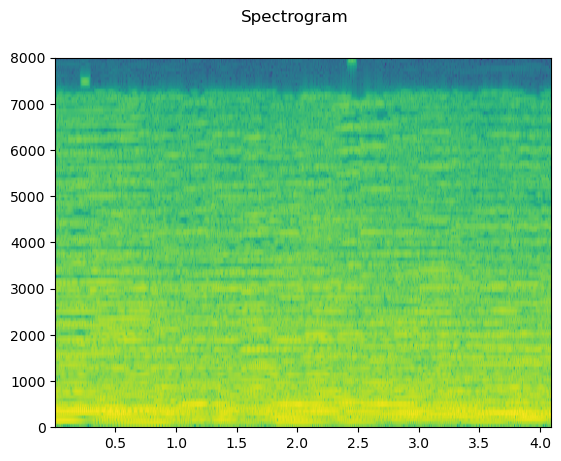

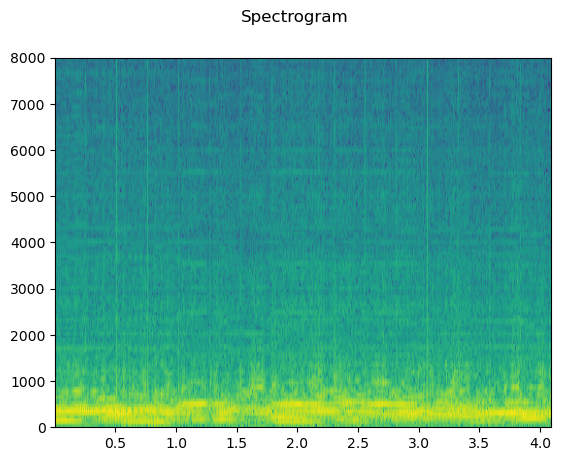

In [6]:
audio_tools.plot_specgram(orig_flat, 16000)
audio_tools.plot_specgram(pred_flat, 16000)

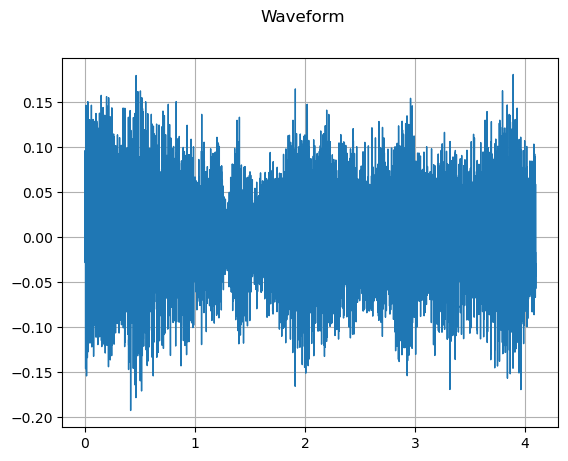

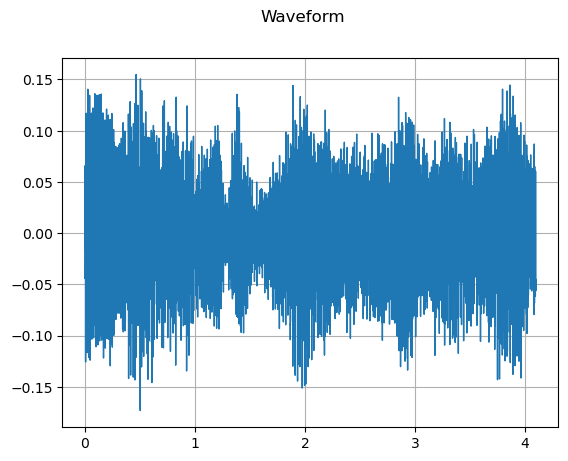

In [7]:
audio_tools.plot_waveform(orig_flat, 16000)
audio_tools.plot_waveform(pred_flat, 16000)

In [8]:
audio_tools.play_audio(orig_flat, 16000)
audio_tools.play_audio(pred_flat, 16000)